In [1]:
# Import statements
import pandas as pd
import numpy as np 
import csv 
import json
import re
import math

In [7]:
'''
Loads the dataframe from Query 1 and Query 2 and merges + drops duplicates and NaNs
    @param: csv1: path to CSV 1 (formed by Query 1)
    @param: csv2: path to CSV 2 (formed by Query 2)
    @return: df1: a merged dataframe of csv1 and csv2
'''
def loadBacktestData(csv1, csv2):
    df1 = pd.read_csv(csv1)
    df2 = pd.read_csv(csv2)
    df1 = df1.append(df2)
    df1_ = df1.drop_duplicates(subset=['Organization Name'])
    df1 = df1_[df1_.Founders.notna()]
    df1 = df1[df1.LinkedIn.notna()]
    df1 = df1.reset_index()
    for i in range(len(df1)):
        if df1.iloc[i].LinkedIn.count('about') > 0:
            df1['LinkedIn'][i] = df1['LinkedIn'][i].split('about')[0]
    df1 = df1.set_index('Organization Name')
    df1 = df1.drop('index', 1)
    df1['Organization Name'] = df1.index
    df1_ = df1_.set_index('Organization Name')
    return df1, df1_

# Loads and combines both CSVs into df1 dataframe
df1, df1_ = loadBacktestData('FailedCompanies.csv', 'notFundedCompanies.csv')
#df3, df3_ = loadBacktestData('FailedCompanies.csv', 'FailedCompanies.csv')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
'''
Method to save the company data as a txt file (loadable as JSON)
    @param: data: company_data dictionary of Company objects
    @return: None
'''
def saveData(data, fileName):
    data_json = json.dumps(data, default=lambda x: x.__dict__)
    with open(fileName, 'w') as outfile:
        json.dump(data_json, outfile)

'''
Method to load company data into a dictionary (same structure as Company object)
    @param: dataFile: string path to saved txt file
    @return: dataDict: a dictionary with the same structure as a Company object
'''
def loadData(dataFile):
    with open(dataFile) as json_file:
        data = json.load(json_file)
    dataDict = json.loads(data)
    return dataDict

In [9]:
alldata = loadData('failedData.txt')
#faileddata = loadData('failed1.txt')

In [10]:
'''
Structure of Company Dictionary Entry:
    @name - string for the company's name
    @description - string for a company description
    @founders - list of founder dictionaries (single founders)
        Structure of Founder Dictionary Entry
            @name - string for the founder's name
            @connections - string for the founder's # of connections
            @location - string for the founder's location 
            @education - list of education dictionaries (single education experiences)
                Structure of Education Dictionary Entry
                    @school - string for the school name
                    @degree - string for the degree objective (i.e. BS / BA)
                    @field - string for the field studied (i.e. Computer Science)
            @experience - list of experience dictionaries (single experiences)
                Structure of Experience Dictionary Entry
                    @companyName - string for the company's name
                    @title - string for the position held at the company
                    @dates - string for the dates worked at the company (i.e. May 2000 - Jun 2000)
    @industries - list of strings with the industries the company is involved in 
    @website - string for the company's website
    @lastStage - string for the last stage of funding received (i.e. Series A)
    @linkedin - string for the URL of the company's LI profile
    @location - string for the company's HQ location
'''
pass

In [11]:
df1_.index[0]

'JOANY'

In [12]:
'''
Data Validation: Location
    Please note: county can also mean 'state'
'''
drop_city = {} ; drop_country = {} ; keep_city = {} ; keep_country = {}
drop_county = {} ; keep_county = {}
for i in range(len(df1_)):
    split_item = df1_.iloc[i]['Headquarters Location'].split(',')
    if df1_.index[i] not in alldata:
        if split_item[0] not in drop_city:
            drop_city[split_item[0]] = 1
        else:
            drop_city[split_item[0]] += 1
        if split_item[-1] not in drop_country:
            drop_country[split_item[-1]] = 1
        else:
            drop_country[split_item[-1]] += 1
        if split_item[1] not in drop_county:
            drop_county[split_item[1]] = 1
        else:
            drop_county[split_item[1]] += 1
    else:
        if split_item[0] not in keep_city:
            keep_city[split_item[0]] = 1
        else:
            keep_city[split_item[0]] += 1
        if split_item[-1] not in keep_country:
            keep_country[split_item[-1]] = 1
        else:
            keep_country[split_item[-1]] += 1
        if split_item[1] not in keep_county:
            keep_county[split_item[1]] = 1
        else:
            keep_county[split_item[1]] += 1

drop_city = {k: v for k, v in sorted(drop_city.items(), key=lambda item: item[1], reverse=True)}
drop_country = {k: v for k, v in sorted(drop_country.items(), key=lambda item: item[1], reverse=True)}
keep_city = {k: v for k, v in sorted(keep_city.items(), key=lambda item: item[1], reverse=True)}
keep_country = {k: v for k, v in sorted(keep_country.items(), key=lambda item: item[1], reverse=True)}
drop_county = {k: v for k, v in sorted(keep_county.items(), key=lambda item: item[1], reverse=True)}
keep_county = {k: v for k, v in sorted(keep_county.items(), key=lambda item: item[1], reverse=True)}

for (i,j) in [(drop_country, keep_country), (drop_city, keep_city), (drop_county, keep_county)]:
    df_1 = pd.DataFrame.from_dict(i, orient='index', columns=['freq']).reset_index()
    df_2 = pd.DataFrame.from_dict(j, orient='index', columns=['freq']).reset_index()
    df_item = pd.merge(df_1, df_2, on='index')
    df_item.columns = ['name', 'dropped', 'kept']
    df_item['dropped'] /= df_item['dropped'].sum()
    df_item['kept'] /= df_item['kept'].sum()
    df_item.set_index(['name'])
df_item.head(10)

,name,dropped,kept
0,California,0.156863,0.156863
1,England,0.065359,0.065359
2,New York,0.053377,0.053377
3,Ontario,0.023965,0.023965
4,Ile-de-France,0.023965,0.023965
5,Texas,0.022876,0.022876
6,Florida,0.019608,0.019608
7,Washington,0.018519,0.018519
8,Alberta,0.018519,0.018519
9,Georgia,0.017429,0.017429


In [13]:
'''
Data Validation: Industries
'''     
drop_industries = {}
for name_ in df1_.index:
    for ind_ in [i.strip() for i in df1_.loc[name_]['Industries'].split(',')]:
        if ind_ not in drop_industries:
            drop_industries[ind_] = 1
        else:
            drop_industries[ind_] += 1
drop_industries = {k: v for k, v in sorted(drop_industries.items(), key=lambda item: item[1], reverse=True)} 
df_dropIndustries = pd.DataFrame.from_dict(drop_industries, orient='index', columns=['freq']).reset_index()

kept_industries = {}
for name_ in alldata.keys():
    for ind_ in [i.strip() for i in df1.loc[name_]['Industries'].split(',')]:
        if ind_ not in kept_industries:
            kept_industries[ind_] = 1
        else:
            kept_industries[ind_] += 1
kept_industries = {k: v for k, v in sorted(kept_industries.items(), key=lambda item: item[1], reverse=True)}

# Brings it into a dataframe
df_keptIndustries = pd.DataFrame.from_dict(kept_industries, orient='index', columns=['freq']).reset_index()
df_industries = pd.merge(df_dropIndustries, df_keptIndustries, on='index')
df_industries.columns = ['name', 'dropped', 'kept']
df_industries['dropped'] /= df_industries['dropped'].sum()
df_industries['kept'] /= df_industries['kept'].sum()
df_industries.set_index(['name'])
df_industries.head(10)

,name,dropped,kept
0,Software,0.194694,0.188830
1,Information Technology,0.071197,0.071375
2,SaaS,0.053827,0.053594
3,Internet,0.033594,0.033058
4,Mobile Apps,0.021187,0.019534
5,B2B,0.019851,0.020786
6,Apps,0.019088,0.015778
7,Mobile,0.018324,0.017280
8,Artificial Intelligence,0.017942,0.017531
9,E-Commerce,0.017942,0.016779


In [14]:
'''
General Data:
    # of Founders
    % Female Founders
    Median Funding Amount
'''
# Import Statement
import gender_guesser.detector as gender

d = gender.Detector()
numFounders = [] ; numFoundersDict = {} ; fundingAmount = [] ; genderDict = {} ;
femaleComp = 0 ; totalComp = 0
for i in range(len(df1)):
    founders_ = df1.iloc[i]['Founders'].split(',')
    amount_ = df1.iloc[i]['Last Funding Amount Currency (in USD)']
    if founders_:
        numFounders.append(len(founders_))
        hasWomen = False ; totalComp += 1
        for founder in founders_:
            founder = founder.strip()
            if founder:
                name = founder.split(' ')[0].strip()
                gen_ = d.get_gender(name)
                if gen_ not in genderDict:
                    genderDict[gen_] = 1
                else:
                    genderDict[gen_] += 1
                if not hasWomen:
                    if gen_ == "mostly_female" or gen_ == "female":
                        femaleComp += 1
                        hasWomen = True
    if amount_ and not math.isnan(amount_):
        try:
            fundingAmount.append(int(amount_))
        except:
            pass
print("Average number of founders is {}".format(str(np.mean(numFounders))))
print("Median number of founders is {}".format(str(np.median(numFounders))))
print("Mean funding amount is ${}".format(str(np.mean(fundingAmount))))
print("Median funding amount is ${}".format(str(np.median(fundingAmount))))
print(genderDict)
print("At least 1 female founder: {}".format(str((femaleComp + (genderDict['andy']/2))/totalComp)))

ModuleNotFoundError: No module named 'gender_guesser'

In [15]:
'''
General Data:
    Number of Founders by region
'''
countryFounders = {} ; countryByFounders = {}
for i in range(len(df1)):
    founders_ = len(df1.iloc[i]['Founders'].split(','))
    country_ = df1_.iloc[i]['Headquarters Location'].split(',')[-1]
    if not country_ in countryFounders:
        countryFounders[country_] = []
        countryFounders[country_].append(founders_)
    else:
        countryFounders[country_].append(founders_)
    if not country_ in countryByFounders:
        countryByFounders[country_] = founders_
    else:
        countryByFounders[country_] += founders_
averageFounders = {}
for country_ in countryFounders.keys():
    averageFounders[country_] = np.mean(countryFounders[country_])
averageFounders = {k: v for k, v in sorted(averageFounders.items(), key=lambda item: item[1], reverse=True)}                   
countryByFounders = {k: v for k, v in sorted(countryByFounders.items(), key=lambda item: item[1], reverse=True)}
df_countryFounders = pd.DataFrame.from_dict(countryByFounders, orient='index', columns=['freq']).reset_index()
df_averageFounders = pd.DataFrame.from_dict(averageFounders, orient='index', columns=['freq']).reset_index()
df_numFounders = pd.merge(df_countryFounders, df_averageFounders, on='index')
df_numFounders.columns = ['name', 'total', 'average']
df_numFounders.head(10)

,name,total,average
0,United States,824,1.698969
1,United Kingdom,148,1.510204
2,Canada,85,1.634615
3,Germany,55,1.617647
4,France,44,1.571429
5,Australia,31,1.550000
6,Spain,28,1.555556
7,The Netherlands,24,1.600000
8,Switzerland,23,1.642857
9,Romania,19,1.900000


In [16]:
type(df1.iloc[0]['Last Funding Amount Currency (in USD)'])

numpy.float64

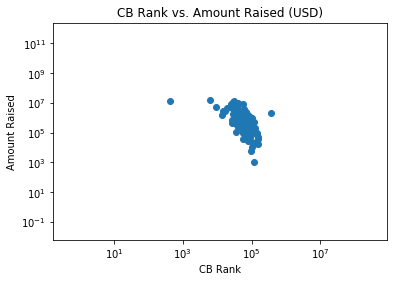

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     24.13
Date:                Thu, 13 Aug 2020   Prob (F-statistic):           3.03e-06
Time:                        11:46:34   Log-Likelihood:                -1881.4
No. Observations:                 116   AIC:                             3767.
Df Residuals:                     114   BIC:                             3772.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        3.72e+06   4.86e+05      7.654      0.0

In [17]:
import statsmodels.api as sm
from matplotlib import pyplot as plt
'''
General Data
    Regress funding against CB rank
'''
X = [] ; Y = []
for i in range(len(df1)):
    pos = df1.iloc[i]
    if not math.isnan(pos['Last Funding Amount Currency (in USD)']):
        y = pos['Last Funding Amount Currency (in USD)']
        x = int(pos['CB Rank (Company)'].replace(',',''))
        X.append(x)
        Y.append(y)
plt.xscale('log') ; plt.yscale('log') ; plt.scatter(X, Y) 
plt.xlabel('CB Rank') ; plt.ylabel('Amount Raised') ; 
plt.title('CB Rank vs. Amount Raised (USD)') ; plt.show()
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
print(model.summary())

In [18]:
'''
Data Validation: Rounds
'''
keptRoundNames = {} ; droppedRoundNames = {}
for name_ in df1_.index:
    round_ = df1_.loc[name_]['Last Funding Type']
    if name_ not in alldata.keys():
        if round_ not in droppedRoundNames:
            droppedRoundNames[round_] = 1
        else:
            droppedRoundNames[round_] += 1
    else:
        if round_ not in keptRoundNames:
            keptRoundNames[round_] = 1
        else:
            keptRoundNames[round_] += 1
print("Dropped round: {}".format(str(droppedRoundNames)))
print("Kept round: {}".format(str(keptRoundNames)))

Dropped round: {'Series A': 7, 'Seed': 73, 'Pre-Seed': 3, nan: 237}
Kept round: {'Series A': 23, 'Seed': 125, 'Pre-Seed': 7, nan: 763}


In [19]:
'''
Loads top schools data
'''
topSchools = pd.read_csv('topSchools.csv', index_col="Score_Rank")
topSchools = topSchools[['University', 'General_name']].head(100)

In [20]:
'''
Pedigree
    1. Do the majority of successful founders attend a top university?
'''
topcount = 0 ; schoolDict = {} ; founderCount = 0 ; schoolFound = False
for key in alldata.keys():
    if alldata[key]['founders']:
        for founder in alldata[key]['founders']:
            if founder['education']:
                founderCount += 1 ; schoolFound = False
                for educ_ in founder['education']:
                    school_ = educ_['school'].lower()
                    if school_ not in schoolDict:
                        schoolDict[school_] = 1
                    else:
                        schoolDict[school_] += 1
                    if not schoolFound:
                        for topSchool_ in topSchools['University']:
                            if school_ in topSchool_.lower():
                                topcount += 1
                                schoolFound = True
                                break
                    if not schoolFound:
                        for topSchool_ in topSchools['General_name']:
                            if topSchool_ in school_.lower():
                                topcount += 1
                                schoolFound = True
                                break
schoolDict = {k: v for k, v in sorted(schoolDict.items(), key=lambda item: item[1], reverse=True)}                   
print("{} % of founders attended a Top 100 School at some point in their education".format(str(topcount / founderCount * 100)))

print("Top schools attended:")
count = 1
for k in schoolDict.keys():
    if count <= 10:
        print("{}. {}".format(str(count), k))
        count += 1
    else:
        break

df_school = pd.DataFrame.from_dict(schoolDict, orient='index', columns=['freq']).reset_index()

28.57142857142857 % of founders attended a Top 100 School at some point in their education
Top schools attended:
1. university of alberta
2. stanford university
3. harvard university
4. massachusetts institute of technology
5. wroclaw university of science and technology
6. new york university
7. university of california, berkeley
8. university of illinois at urbana-champaign
9. ucl
10. georgia institute of technology


In [21]:
'''
Pedigree
    2. Do the majority of successful founders attend graduate school?
'''
degreeDict = {} ; degreeCount = 0 ; gradCount = 0

def checkGraduateEducation(founder, degreeDict, degreeCount):
    if founder['education']:
        checkDegree = True
        for educ_ in founder['education']:
            if educ_['degree']:
                deg_ = educ_['degree'].lower()
                if checkDegree:
                    degreeCount += 1
                    checkDegree = False
                if deg_ not in degreeDict:
                    degreeDict[deg_] = 1
                else:
                    degreeDict[deg_] += 1
    return degreeDict, degreeCount

for key in alldata.keys():
    if alldata[key]['founders']:
        for founder in alldata[key]['founders']:
            degreeDict, degreeCount = checkGraduateEducation(founder, degreeDict, degreeCount)

degreeDict = {k: v for k, v in sorted(degreeDict.items(), key=lambda item: item[1], reverse=True)}  
for key in degreeDict.keys():
    if key in ['mba', 'ms', 'msc', 'ph.d', 'phd', 'ma', 'jd', 'ph.d', 'md', 'mse', 'meng'] or 'master' in key or 'm.' in key or 'doctor' in key:
        gradCount += 1
print("{} percent of founders have postgraduate education".format(str(gradCount / degreeCount * 100)))

14.955357142857142 percent of founders have postgraduate education


In [22]:
'''
Pedigree
    3. Do successful founders study certain fields over others?
'''
fieldDict = {}

def getFields(founder, fieldDict):
    if founder['education']:
        for educ_ in founder['education']:
            if educ_['field']:
                field = educ_['field'].lower()
                if field not in fieldDict:
                    fieldDict[field] = 1
                else:
                    fieldDict[field] += 1
    return fieldDict

for key in alldata.keys():
    if alldata[key]['founders']:
        for founder in alldata[key]['founders']:
            fieldDict = getFields(founder, fieldDict)

fieldDict = {k: v for k, v in sorted(fieldDict.items(), key=lambda item: item[1], reverse=True)}
count = 0 ; totalCount = 0
computerFields = {} ; breakCount = 0
print("Most commonly studied fields:")
for k in fieldDict.keys():
    if breakCount < 10:
        print("{}. {}".format(str(breakCount+1), k))
        breakCount += 1
    if 'computer' in k:
        count += fieldDict[k]
        computerFields[k] = fieldDict[k]
    totalCount += fieldDict[k]
df_fields = pd.DataFrame.from_dict(fieldDict, orient='index', columns=['freq']).reset_index()
df_fields.head(10)
print("Percentage of founders that studied CS and related fields: {}%".format(str(100 * count/totalCount)))


Most commonly studied fields:
1. computer science
2. business administration and management, general
3. mechanical engineering
4. economics
5. finance
6. computer engineering
7. information technology
8. marketing
9. computer software engineering
10. business administration
Percentage of founders that studied CS and related fields: 16.1231884057971%


In [23]:
'''
Employment Background
    1. Do most founders have experience at startups (CEO, CFO, CTO, COO, Founder)
'''
posDict = {} ; ceosList = [] ; ctosList = []
for key in alldata.keys():
    if alldata[key]['founders']:
        for founder in alldata[key]['founders']:
            if founder['experience']:
                firstCheck = True ; ceoCheck = False ; ctoCheck = False
                for exp_ in founder['experience']:
                    if (not key.split(' ')[0] in exp_['companyName']):
                        if exp_['title']:
                            if 'founder' in exp_['title'].lower() and firstCheck:
                                pass
                            else:
                                pos = exp_['title'].lower()
                                if pos not in posDict:
                                    posDict[pos] = 1
                                else:
                                    posDict[pos] += 1
                            firstCheck = False
                            if not ceoCheck:
                                if 'ceo' in exp_['title'].lower() or 'executive officer' in exp_['title'].lower():
                                    ceosList.append(founder)
                                    ceoCheck = True
                            if not ctoCheck:
                                if 'cto' == exp_['title'].lower() or ' cto' in exp_['title'].lower() or 'cto ' in exp_['title'].lower() or 'technology officer' in exp_['title'].lower() or 'technical officer' in exp_['title'].lower():
                                    ctosList.append(founder)
                                    ctoCheck = True
posDict = {k: v for k, v in sorted(posDict.items(), key=lambda item: item[1], reverse=True)}

df_pos = pd.DataFrame.from_dict(posDict, orient='index', columns=['freq']).reset_index()
print("Previous titles held by founders:")
df_pos.head(10)

Previous titles held by founders:


,index,freq
0,co-founder,80
1,founder,58
2,software engineer,52
3,ceo,40
4,owner,35
5,mentor,34
6,board member,33
7,advisor,31
8,managing director,29
9,president,29


In [24]:
'''
Pedigree & Employment:
    Profiles of CEOs vs. CTOs
'''
degreeDict = {} ; degreeCount = 0 ; gradCount = 0
for cto in ctosList:
    degreeDict, degreeCount = checkGraduateEducation(cto, degreeDict, degreeCount)
    
degreeDict = {k: v for k, v in sorted(degreeDict.items(), key=lambda item: item[1], reverse=True)}  
for key in degreeDict.keys():
    if key in ['mba', 'ms', 'msc', 'ph.d', 'phd', 'ma', 'jd', 'ph.d', 'md', 'mse', 'meng'] or 'master' in key or 'm.' in key or 'doctor' in key:
        gradCount += 1
print("{} percent of CTOs have postgraduate education".format(str(gradCount / degreeCount * 100)))

degreeDict = {} ; degreeCount = 0 ; gradCount = 0
for ceo in ceosList:
    degreeDict, degreeCount = checkGraduateEducation(ceo, degreeDict, degreeCount)

degreeDict = {k: v for k, v in sorted(degreeDict.items(), key=lambda item: item[1], reverse=True)}  
for key in degreeDict.keys():
    if key in ['mba', 'ms', 'msc', 'ph.d', 'phd', 'ma', 'jd', 'ph.d', 'md', 'mse', 'meng'] or 'master' in key or 'm.' in key or 'doctor' in key:
        gradCount += 1
print("{} percent of CEOs have postgraduate education".format(str(gradCount / degreeCount * 100)))

fieldDict = {}
for ceo in ceosList:
    fieldDict = getFields(ceo, fieldDict)
    
fieldDict = {k: v for k, v in sorted(fieldDict.items(), key=lambda item: item[1], reverse=True)}
count = 0 ; totalCount = 0
computerFields = {} ; breakCount = 0
print("Most commonly studied fields CEO:")
for k in fieldDict.keys():
    if breakCount < 10:
        print("{}. {}".format(str(breakCount+1), k))
        breakCount += 1
    if 'computer' in k or 'cs' == k or 'software' in k or 'data' in k or 'engine' in k:
        count += fieldDict[k]
        computerFields[k] = fieldDict[k]
    totalCount += fieldDict[k]
df_fields = pd.DataFrame.from_dict(fieldDict, orient='index', columns=['freq']).reset_index()
df_fields.head(10)
print("Percentage of CEOs that studied CS and engineering fields: {}%".format(str(100 * count/totalCount)))

fieldDict = {}
for cto in ctosList:
    fieldDict = getFields(cto, fieldDict)

fieldDict = {k: v for k, v in sorted(fieldDict.items(), key=lambda item: item[1], reverse=True)}
count = 0 ; totalCount = 0
computerFields = {} ; breakCount = 0
print("Most commonly studied fields CTO:")
for k in fieldDict.keys():
    if breakCount < 10:
        print("{}. {}".format(str(breakCount+1), k))
        breakCount += 1
    if 'computer' in k or 'cs' == k or 'software' in k or 'data' in k or 'engine' in k:
        count += fieldDict[k]
        computerFields[k] = fieldDict[k]
    totalCount += fieldDict[k]
df_fields = pd.DataFrame.from_dict(fieldDict, orient='index', columns=['freq']).reset_index()
df_fields.head(10)
print("Percentage of CTOs that studied CS and engineering fields: {}%".format(str(100 * count/totalCount)))

founderCount = 0 ; schoolDict = {}
for founder in ceosList:
    if founder['education']:
        founderCount += 1 ; schoolFound = False
        for educ_ in founder['education']:
            school_ = educ_['school'].lower()
            if school_ not in schoolDict:
                schoolDict[school_] = 1
            else:
                schoolDict[school_] += 1
schoolDict = {k: v for k, v in sorted(schoolDict.items(), key=lambda item: item[1], reverse=True)}
df_schoolCEOs = pd.DataFrame.from_dict(schoolDict, orient='index', columns=['freq']).reset_index()
print("CEO Schools:")
print(df_schoolCEOs.head(10))

founderCount = 0 ; schoolDict = {}
for founder in ctosList:
    if founder['education']:
        founderCount += 1 ; schoolFound = False
        for educ_ in founder['education']:
            school_ = educ_['school'].lower()
            if school_ not in schoolDict:
                schoolDict[school_] = 1
            else:
                schoolDict[school_] += 1
schoolDict = {k: v for k, v in sorted(schoolDict.items(), key=lambda item: item[1], reverse=True)}
df_schoolCTOs = pd.DataFrame.from_dict(schoolDict, orient='index', columns=['freq']).reset_index()
print("CTO Schools:")
print(df_schoolCTOs.head(10))

21.666666666666668 percent of CTOs have postgraduate education
25.595238095238095 percent of CEOs have postgraduate education
Most commonly studied fields CEO:
1. computer science
2. business administration and management, general
3. economics
4. accounting and finance
5. information technology
6. mechanical engineering
7. mathematics
8. english
9. finance, general
10. finance
Percentage of CEOs that studied CS and engineering fields: 19.093851132686083%
Most commonly studied fields CTO:
1. computer science
2. information technology
3. ingeniería informática
4. economics
5. computer engineering
6. computing, entrepreneurship, and innovation - nyu courant institute and nyu stern school of business
7. applied mathematics
8. applied mathematics and physics
9. software engineering
10. computer and information sciences
Percentage of CTOs that studied CS and engineering fields: 46.391752577319586%
CEO Schools:
                                               index  freq
0                      

In [30]:
'''
Employment:
    Profiles of CEOs 
'''
titleDict={}
founderCount = 0
print("Previous titles held by CEOs:")
for ceo in ceosList:
    if ceo['experience']:
        firstCheck = True; 
        for exp in ceo['experience']:
            if exp['title']:
                if 'ceo' in exp['title'].lower() or 'executive officer' in exp['title'].lower() and firstCheck:
                    pass
                else:
                    position = exp['title'].lower()
                    if position not in titleDict:
                        titleDict[position] = 1
                    else:
                        titleDict[position] += 1
                firstCheck = False
titleDict = {k: v for k, v in sorted(titleDict.items(), key=lambda item: item[1], reverse=True)}
df_positions = pd.DataFrame.from_dict(titleDict, orient='index', columns=['freq']).reset_index()
df_positions.head(15)




Previous titles held by CEOs:


,index,freq
0,founder,42
1,co-founder,33
2,mentor,10
3,owner,9
4,president,9
5,board member,8
6,managing partner,7
7,entrepreneur in residence,7
8,advisor,7
9,coo,5


In [31]:
founderCount = 0
total =0
for key in titleDict.keys():
    total =total+1
    if 'founder' in key:
        founderCount += 1
print("{} percent of failed CEOs have founding experience".format(str(founderCount/total*100)))


11.791383219954648 percent of failed CEOs have founding experience


In [32]:
'''
Employment:
    Profiles of CTOs 
'''
titleDict={}
founderCount = 0
print("Previous titles held by CEOs:")
for cto in ctosList:
    if cto['experience']:
        firstCheck = True; 
        for exp in cto['experience']:
            if exp['title']:
                if 'cto' in exp['title'].lower() or ' cto' in exp['title'].lower() or 'cto ' in exp['title'].lower() or 'technology officer' in exp_['title'].lower() or 'technical officer' in exp_['title'].lower() and firstCheck:
                    pass
                else:
                    position = exp['title'].lower()
                    if position not in titleDict:
                        titleDict[position] = 1
                    else:
                        titleDict[position] += 1
                firstCheck = False
titleDict = {k: v for k, v in sorted(titleDict.items(), key=lambda item: item[1], reverse=True)}
df_positions = pd.DataFrame.from_dict(titleDict, orient='index', columns=['freq']).reset_index()
df_positions.head(15)



Previous titles held by CEOs:


,index,freq
0,chief technology officer,21
1,co-founder,11
2,founder,9
3,founder & ceo,8
4,software engineer,8
5,senior software engineer,6
6,software developer,5
7,ceo,5
8,developer,3
9,interim chief technology officer,3


In [34]:
founderCount = 0
total =0
for key in titleDict.keys():
    total =total+1
    if 'founder' in key:
        founderCount += 1
print("{} percent of failed CTOs have founding experience".format(str(founderCount/total*100)))


17.105263157894736 percent of failed CTOs have founding experience


In [35]:
'''
Employment Background (1) contd.
'''
entrepCount = 0 ; techCount = 0 ; busCount = 0 ; totalCount = 0
for i in range(len(df_pos)):
    pos = df_pos.iloc[i]
    totalCount += pos['freq']
    if 'founder' in pos['index'] or 'ceo' in pos['index'] or 'executive' in pos['index'] or 'board' in pos['index'] or 'president' in pos['index']:
        entrepCount += pos['freq']
    if ('engineer' in pos['index'] or 'cto' in pos['index'] or 'technology' in pos['index'] or 'computer' in pos['index'] or 'developer' in pos['index'] or 
        'science' in pos['index'] or 'data' in pos['index'] or 'research' in pos['index']):
        techCount += pos['freq']
    if ('business' in pos['index'] or 'analyst' in pos['index'] or 'product' in pos['index'] or 'manager' in pos['index'] or 'director' in pos['index'] or 
        'coo' in pos['index'] or 'operating' in pos['index'] or 'associate' in pos['index'] or 'financ' in pos['index'] or 'vp' in pos['index'] or 
        'consultant' in pos['index']):
        busCount += pos['freq']
print("{} percent entrepreneurial/executive".format(str(entrepCount * 100 / totalCount)))
print("{} percent tech".format(str(techCount * 100 / totalCount)))
print("{} percent business/finance/consulting".format(str(busCount * 100 / totalCount)))

19.366197183098592 percent entrepreneurial/executive
25.975081256771396 percent tech
31.338028169014084 percent business/finance/consulting


In [36]:
'''
Employment Background
    2. Do founders have a lot of LinkedIn Connections
'''
connectDict = {} ; countDict = {} ; numFounders = 0 ; totalConnections = 0
for key in alldata.keys():
    numFounders_ = 0 
    try:
        for founder in alldata[key]['founders']:
            if founder['connections']:
                num = int([j for i in founder['connections'].split(' ') for j in i.split('+')][0])
                numFounders += 1 ; totalConnections += num
                numFounders_ += 1
                if key not in connectDict:
                    connectDict[key] = num
                else:
                    connectDict[key] += num
        connectDict[key] /= numFounders_
        countDict[key] = numFounders_
    except Exception as e:
        pass

print("Average number of connections is {}".format(str(totalConnections / numFounders)))

top100count = 0 ; top100founderCount = 0
for top_ in df1['Organization Name'][:100]:
    if top_ in connectDict:
        top100count += connectDict[top_] * countDict[top_]
        top100founderCount += countDict[top_]
print("Average number of connections in Top 100: {}".format(str(top100count / top100founderCount)))

Average number of connections is 433.8317843866171
Average number of connections in Top 100: 443.7037037037037


In [37]:
'''
Employment Background
    3. Do founders come from certain job positions prior to starting their company? 
        - are they prior founders?
        - are they prior software engineers
'''
df_pos.head(10)

,index,freq
0,co-founder,80
1,founder,58
2,software engineer,52
3,ceo,40
4,owner,35
5,mentor,34
6,board member,33
7,advisor,31
8,managing director,29
9,president,29


In [38]:
'''
Employment Background
    4. Do founders come from certain companies (or industries)
'''
expDict_raw = {} ; expDict = {}
for key in alldata.keys():
    for founder in alldata[key]['founders']:
        if founder['experience']:
            for exp_ in founder['experience']:
                exp_name = exp_['companyName'].lower()
                if exp_name not in expDict_raw:
                    expDict_raw[exp_name] = 1
                else:
                    expDict_raw[exp_name] += 1
                short_name = re.split('\\s+|\\.|,', exp_name)
                for word in short_name:
                    if word in expDict.keys():
                        expDict[word] += 1
                    else:
                        expDict[word] = 1
expDict = {k: v for k, v in sorted(expDict.items(), key=lambda item: item[1], reverse=True)}
expDict;

expDict_raw = {k: v for k, v in sorted(expDict_raw.items(), key=lambda item: item[1], reverse=True)}
expDict_raw

{'microsoft': 16,
 'facebook': 14,
 'apple': 12,
 'self-employed': 12,
 'google': 11,
 'freelance': 10,
 'accenture': 8,
 'ibm': 7,
 'bmw group': 6,
 'techstars': 6,
 '3d talo finland oy': 6,
 'at&t': 5,
 'self employed': 5,
 'amazon': 5,
 'deloitte': 5,
 'boy scouts of america': 5,
 'flair digital': 5,
 'linkedin': 5,
 'westpac': 5,
 'seasonally fresh, inc': 5,
 'google full-time': 4,
 'founders network': 4,
 'toastmasters international': 4,
 'capgemini': 4,
 'productivist': 4,
 'freelabster': 4,
 'university of alberta': 4,
 'freelancer': 4,
 'qualysoft': 4,
 'aviva plc': 4,
 'twitter': 4,
 '3d talo': 4,
 'salesforce': 4,
 'ericsson': 4,
 'blackbelt technology kft.': 4,
 'brandox': 4,
 'cruise': 4,
 'twitter full-time': 4,
 'gizlo': 4,
 'appselent': 3,
 'arobs transilvania software': 3,
 'capital one': 3,
 '...': 3,
 'smplicity': 3,
 'nokia': 3,
 'university of pennsylvania': 3,
 'shell': 3,
 'socialbeat': 3,
 'intel corporation': 3,
 'hubroad': 3,
 '1871': 3,
 'canadian armed forces

In [32]:
'''
Employment Background
    5. Are there certain words or phrases in a founder's prior job description that stand out
'''
expDict

{'': 129,
 'full-time': 67,
 'inc': 62,
 'of': 38,
 'the': 27,
 'university': 22,
 'llc': 19,
 '&': 14,
 'freelance': 13,
 '-': 12,
 'self-employed': 11,
 '(acquired': 11,
 'by': 11,
 'and': 11,
 'ai': 10,
 'health': 9,
 'company': 9,
 'facebook': 9,
 'part-time': 9,
 'for': 9,
 'systems': 9,
 'technology': 9,
 'corporation': 9,
 '|': 9,
 'perfect': 9,
 'center': 8,
 'group': 8,
 'digital': 8,
 'capital': 8,
 'web': 7,
 'media': 7,
 'io': 7,
 'com': 7,
 'google': 7,
 'institute': 7,
 'school': 7,
 'cruise': 6,
 'ltd': 6,
 'solutions': 6,
 'innovation': 6,
 'partners': 6,
 'tech': 6,
 'energy': 6,
 'technologies': 6,
 'haven': 6,
 'academy': 6,
 'consulting': 6,
 'solutech': 6,
 'scroll': 6,
 'engineering': 6,
 'techstars': 5,
 'software': 5,
 'america': 5,
 'science': 5,
 'a': 5,
 'business': 5,
 'ventures': 5,
 'network': 5,
 'association': 5,
 'venture': 5,
 'new': 5,
 'labs': 4,
 'dashride': 4,
 'y': 4,
 'combinator': 4,
 'salesforce': 4,
 'networks': 4,
 'blue': 4,
 'amazon': 4,
 '

In [39]:
'''
Company Fundamentals 
    1. How important is the company's CB rank?
'''
ranks = [int(i.replace(',','')) for i in df1['CB Rank (Company)']]
print("Mean CB rank is: {}".format(np.mean(ranks)))
print("Among the top 200 companies, the mean rank is {}".format(str(np.mean(ranks[:200]))))

Mean CB rank is: 389326.454248366
Among the top 200 companies, the mean rank is 259258.72


In [40]:
'''
Company Fundamentals
    2. Are there keywords in a company's description?
'''
descriptionWords = {}
for des_ in df1['Description']:
    for word in re.split('\\s|\.|,',des_):
        if word:
            if word not in descriptionWords:
                descriptionWords[word] = 1
            else:
                descriptionWords[word] += 1
descriptionWords = {k: v for k, v in sorted(descriptionWords.items(), key=lambda item: item[1], reverse=True)}
descriptionWords

{'and': 515,
 'a': 304,
 'is': 300,
 'to': 296,
 'for': 254,
 'the': 194,
 'that': 167,
 'of': 138,
 'platform': 129,
 'software': 124,
 'in': 117,
 'SaaS': 106,
 'with': 84,
 '&': 80,
 'company': 78,
 'Software': 77,
 'an': 72,
 'your': 71,
 'their': 64,
 'development': 63,
 'on': 55,
 'solutions': 52,
 'provides': 52,
 'Development': 49,
 'data': 46,
 'mobile': 45,
 'management': 45,
 'services': 43,
 'business': 43,
 'helps': 41,
 'app': 38,
 'We': 37,
 'web': 35,
 'digital': 34,
 'help': 33,
 'companies': 33,
 'technology': 32,
 'online': 32,
 'based': 31,
 'service': 31,
 'from': 31,
 'businesses': 30,
 'solution': 28,
 'A': 28,
 'you': 27,
 'by': 27,
 'AI': 26,
 'The': 25,
 'tools': 25,
 'tool': 25,
 'Platform': 24,
 'as': 24,
 'offers': 24,
 'users': 23,
 'Mobile': 23,
 'develops': 22,
 'cloud': 22,
 'Web': 22,
 'marketing': 21,
 'application': 21,
 'easy': 20,
 'build': 20,
 'or': 20,
 'through': 20,
 '-': 20,
 'Consulting': 20,
 'applications': 19,
 'industry': 19,
 'into': 19

In [41]:
'''
Company Fundamentals
    3. Number of founders / company location?
    Seems to be covered in General Data above
'''
df1

,Organization Name URL,Industries,Description,Last Funding Amount,Last Funding Amount Currency,Last Funding Amount Currency (in USD),Last Funding Type,CB Rank (Company),Number of Funding Rounds,LinkedIn,Website,Founders,Estimated Revenue Range,Trend Score (90 Days),Top 5 Investors,Headquarters Location,Investment Stage,Organization Name
Organization Name,,,,,,,,,,,,,,,,,,
JOANY,https://www.crunchbase.com/organization/impact...,"Health Care, Insurance, Internet, SaaS",Joany is your trusted healthcare concierge. We...,13000000.0,USD,13000000.0,Series A,410,7.0,https://www.linkedin.com/company/joany/?origin...,https://Joany.com,"Christine Carrillo, Helen Lee",$1M to $10M,9.7,"Techstars, Precursor Ventures, Right Side Capi...","Los Angeles, California, United States",NaN,JOANY
Assembly,https://www.crunchbase.com/organization/assembly,"Apps, Collaboration, Crowdsourcing, Software, ...",Assembly is a web collaboration platform that ...,NaN,NaN,NaN,Seed,"5,967",3.0,https://www.linkedin.com/company/assembly-inc,http://assemblymade.com,"Chris Lloyd, Dave Newman, Matthew Deiters",NaN,7.6,"Y Combinator, Floodgate, BoxGroup, Union Squar...","San Francisco, California, United States",NaN,Assembly
Filament,https://www.crunchbase.com/organization/filame...,"Bitcoin, Blockchain, Hardware, Industrial, Int...",Filament builds blockchain hardware and& softw...,15000000.0,USD,15000000.0,Series A,"6,356",8.0,https://www.linkedin.com/company/filament-netw...,https://filament.com,"Allison Clift-Jennings, Jeremie Miller, Sally ...",Less than $1M,-0.6,"AngelList, Digital Currency Group, Techstars, ...","Reno, Nevada, United States",NaN,Filament
Nudge.ai,https://www.crunchbase.com/organization/nudge-2,"B2B, CRM, Sales, Sales Automation, Social CRM,...",Nudge is a Modern Sales Platform that leverage...,6500000.0,CAD,4970448.0,Seed,"9,064",1.0,http://www.linkedin.com/company/nudgeai,https://nudge.ai,"Paul Teshima, Steven Woods",Less than $1M,-0.3,"OMERS Ventures, Jill Rowley, Neal Dempsey, Bra...","Toronto, Ontario, Canada",NaN,Nudge.ai
Aiden,https://www.crunchbase.com/organization/aiden-2,"Analytics, Artificial Intelligence, Computer, ...",Aiden provides an AI analytics platform intend...,1400000.0,EUR,1601801.0,Seed,"14,044",2.0,https://www.linkedin.com/company/aiden.ai/,http://aiden.ai/,"Marie Outtier, Pierre-Jean Camillieri",NaN,-1.0,"Partech, Kima Ventures, Sophia Bendz, Pierre V...","London, England, United Kingdom",NaN,Aiden
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ioAirFlow,https://www.crunchbase.com/organization/ioairflow,"CleanTech, Green Building, GreenTech, Property...",B2B SaaS in the cleantech and proptech industr...,NaN,NaN,NaN,NaN,"278,729",NaN,https://www.linkedin.com/company/11756184,https://www.ioairflow.com,Matt Schaubroeck,NaN,NaN,NaN,"Winnipeg, Manitoba, Canada",NaN,ioAirFlow
DynaMetrics,https://www.crunchbase.com/organization/dyname...,"Artificial Intelligence, Credit, Finance, FinT...",DynaMetrics is developing an automated credit ...,NaN,NaN,NaN,NaN,"277,785",NaN,https://www.linkedin.com/company/dynametrics/,https://www.dynametrics.ch/,Anne-Liliane Jorand,NaN,NaN,NaN,"Villars-sur-glane, Fribourg, Switzerland",NaN,DynaMetrics
FogChain Corp.,https://www.crunchbase.com/organization/fogcha...,"Computer, Quality Assurance, Software","FogChain is a fully integrated, end-to-end sof...",NaN,NaN,NaN,NaN,"277,636",NaN,https://www.linkedin.com/company/fogchaininc/,https://www.fogchaininc.com/,"Anthony Cerna, James Cerna",NaN,NaN,NaN,"Vancouver, British Columbia, Canada",NaN,FogChain Corp.
